<a href="https://colab.research.google.com/github/Lautz97/Home_Stuff_Classifier_using_CNN/blob/main/ML_hw_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2

Dataset : 
* containers/food_tray 
* tableware/salad_plate 
* drinks/Juice_bottle 
* cutlery/plastic_spoon
* fruits/Tangerines
* snacks/Pretzels
* food/canned_vegetables
* cleaning_stuff/Glass_Cleaners



In [1]:
#@title Importing libraries and useful helpers
!pip install ipython-autotime
%load_ext autotime

from google.colab import files
from google.colab import drive
import json
import pandas as pd
import matplotlib.pyplot as plt

import re

print("importing libraries.......done\n")

%tensorflow_version 2.x

import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

print("Tensorflow version %s" %tf.__version__)
print("\n")

print("Keras version %s" %keras.__version__)
print("\n")

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found, enable it if you want to train a cnn. \n If you want just test it, comment out this line')
print('Found GPU at: {}'.format(device_name))

importing libraries.......done

Tensorflow version 2.4.0


Keras version 2.4.3


Found GPU at: /device:GPU:0
time: 6.95 s (started: 2020-12-23 09:55:01 +00:00)


In [2]:
#@title # Variable settings { run: "auto" }
#@markdown To customize:

#@markdown ### Paths

# in case of retrieving data from g_drive the drive will be mounted
# specify where here
drive_mount_path = "/content/drive" #@param {type:"string"} 
zipped_images = "/My Drive/MLHW2/zipped_images" #@param {type:"string"}
# now specify the directory of the dataset 
# unzipped_images = "/My Drive/MLHW2" #@param {type:"string"}

# @markdown ### Variables
# @markdown resized edge length
edge_len =  "256" #@param ["128", "256", "512"]{type:"string"}
edge_len = int(edge_len)

# @markdown batch size
batch =  "32" #@param ["16", "32", "64"]{type:"string"}
batch = int(batch)

# @markdown # Model Parameters

# @markdown #### Select Model
selected_model =  "AlexNet" #@param ["AlexNet", "LeNet", "ConvNet"]{type:"string"}

# @markdown select optimizer
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
optimizer =  "Adam" #@param ["Adadelta", "Adagrad", "Adam", "Adamax", "Ftrl", "Nadam", "optimizer", "RMSprop", "SGD"]{type:"string"}

# @markdown select loss function
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
loss_fun =  "categorical_crossentropy" #@param ["KLD", "MAE", "MAPE", "MSE", "MSLE", "binary_crossentropy", "categorical_crossentropy", "categorical_hinge", "cosine_similarity", "hinge", "huber", "kld", "poisson"]{type:"string"}

#metrics from keras.metrics are.... broken(?)

#@markdown #Training Options

n_epochs = 100 # @param {type: "integer"}

train_cnn = False # @param {type: "boolean"}

save_model = False # @param {type: "boolean"}
load_model = True # @param {type: "boolean"}

drive_path = './drive/MyDrive/MLHW2' #@param {type:"string"}


print("done!")

done!
time: 10.6 ms (started: 2020-12-23 09:55:08 +00:00)


#Import Dataset

In [3]:
#@markdown Mounting drive in the colab fs copying and unzipping images and cleaning up the ~/content directory

drive.mount(drive_mount_path, force_remount = True)

zip_path = drive_mount_path + zipped_images
!cp -r "{zip_path}" .
!unzip -q ./zipped_images/\* -d ./imgs
!rm -r ./zipped_images
!rm -r ./sample_data 

print()

Mounted at /content/drive

8 archives were successfully processed.

time: 34 s (started: 2020-12-23 09:55:08 +00:00)


# Preprocessing Dataset

In [4]:
#@markdown Using Image Data Generator for differentiating the dataset and generators to divide trining set (80%) and validation set (20%)
directory = "./imgs"

datagen = ImageDataGenerator(
    rescale=1./255,
    fill_mode='reflect',
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    directory=directory,
    batch_size=batch,
    target_size=(edge_len, edge_len),
    class_mode="categorical",
    color_mode="rgb",
    subset="training",
    interpolation="bilinear",
    shuffle=True,
)
test_generator = datagen.flow_from_directory(
    directory=directory,
    batch_size=batch,
    target_size=(edge_len, edge_len),
    class_mode="categorical",
    color_mode="rgb",
    subset="validation",
    interpolation="bilinear",
    shuffle=False,
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))

Found 6980 images belonging to 8 classes.
Found 1742 images belonging to 8 classes.
Image input (256, 256, 3)
Classes: ['Glass_Cleaners', 'Juice_bottle', 'Pretzels', 'Tangerines', 'canned_vegetables', 'food_tray', 'plastic_spoon', 'salad_plate']
Loaded 6980 training samples from 8 classes.
Loaded 1742 test samples from 8 classes.
time: 443 ms (started: 2020-12-23 09:55:42 +00:00)


(256, 256, 3)
food_tray


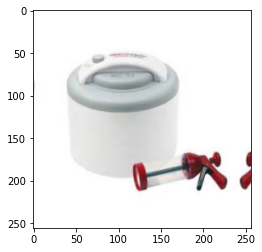

(256, 256, 3)
Juice_bottle


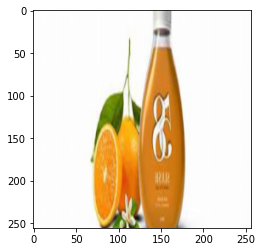

(256, 256, 3)
Tangerines


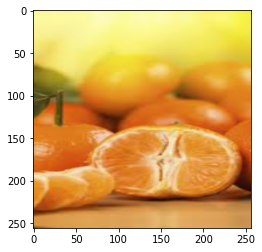

time: 1.09 s (started: 2020-12-23 09:55:42 +00:00)


In [5]:
#@title #####Plotting Random Images from dataset

#just for fun, stolen from ex11
import matplotlib.pyplot as plt

n = 3
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    print(image.shape)
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()

# Convolutional Neural Networks
Contruction layer by layer of all the implemented CNN models

In [6]:
#@title #LeNet model Setup

def LeNet(name="LeNet"):
    
    model = Sequential()
    
    # @markdown C1: Convolutional 6 kernels 5x5
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(edge_len, edge_len, 3), padding='same'))
    
    # @markdown S2: Average Pooling 2x2 stride 2x2
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    
    # @markdown C3: Convolutional 16 kernels 5x5
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    
    # @markdown S4: Average Pooling 2x2 stride 2x2
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    
    # @markdown C5: Convolutional 120 kernels 5x5
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    
    # @markdown 5.5: Flatten to convert n-D  feature map in 1D vector
    model.add(Flatten())
    
    # @markdown F6: Fully connected, 84 units
    model.add(Dense(84, activation='tanh'))
 
    # @markdown F7: Fully connected, 8 units
    model.add(Dense(num_classes, activation='softmax'))
    
    return model
 
# @markdown Use adam or SGD as optimizer and categorical_crossentropy as loss function

time: 20.1 ms (started: 2020-12-23 09:55:43 +00:00)


In [7]:
#@title # ConvNet Setup

def ConvNet(name="ConvNet"): 

  model = Sequential()

  # @markdown C1: Conv2D 32 with "relu" activation function
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(edge_len, edge_len, 3)))
  # @markdown M2: 2D MaxPooling
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # @markdown C3: Conv2D 32 with "relu" activation function
  model.add(Conv2D(32, (3, 3), activation='relu'))
  #@markdown M4: 2D MaxPooling
  model.add(MaxPooling2D(pool_size=(2, 2)))

  #@markdown C5: Conv2D 64 and "relu" activation function
  model.add(Conv2D(64, (3, 3), activation='relu'))
  #@markdown M6: 2D MaxPooling
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # the model so far outputs 3D feature maps (height, width, features)

  # @markdown 6.5: Flatten to convert the 3D feature map to a 1D vector
  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

  # @markdown F7: Fully connected, 64 units with "relu" activation function
  model.add(Dense(64, activation='relu'))

  # @markdown D8: Dropout 0.5 to prevent overfitting
  model.add(Dropout(0.5))

  # @markdown F9: Fully connected, 1 unit with "sigmoid" activation function
  model.add(Dense(num_classes, activation='sigmoid'))

  return model

# @markdown Use adam or SGD as optimizer and categorical_crossentropy as loss function

time: 23.9 ms (started: 2020-12-23 09:55:43 +00:00)


In [8]:
#@title #AlexNet model Setup

def AlexNet(regl2 = 0.0001, lr=0.0001):

    model = Sequential()

    input_shape=(edge_len, edge_len, 3)

    # @markdown C1: Convolutional Layer 
    model.add(Conv2D(filters=96, input_shape=(edge_len, edge_len, 3), kernel_size=(11,11), strides=(2,4), padding='valid'))
    model.add(Activation('relu'))
    # @markdown MaxPooling2D 2x2 stride
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # @markdown Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # @markdown C2: Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # @markdown MaxPooling2D 2x2 stride
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # @markdown Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # @markdown C3: Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # @markdown Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # @markdown C4: Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # @markdown Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # @markdown C5: Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # @markdown MaxPooling2D 2x2 stride
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # @markdown Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # @markdown Flatten to convert n-D  feature map in 1D vector
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)
    
    # @markdown D1: Dense Layer
    model.add(Dense(4096, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # @markdown Dropout(0.4)
    model.add(Dropout(0.4))
    # @markdown Batch Normalisation
    model.add(BatchNormalization())

    # @markdown D2: Dense Layer
    model.add(Dense(4096, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # @markdown Dropout(0.4)
    model.add(Dropout(0.4))
    # @markdown Batch Normalisation
    model.add(BatchNormalization())

    # @markdown D3: Dense Layer
    model.add(Dense(1000,kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # @markdown Dropout(0.4)
    model.add(Dropout(0.4))
    # @markdown Batch Normalisation
    model.add(BatchNormalization())

    # @markdown Output Dense Layer 8 units with softmax activation
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model

# @markdown Use adam or SGD as optimizer and categorical_crossentropy as loss function

time: 75.8 ms (started: 2020-12-23 09:55:43 +00:00)


In [9]:
#@title #Selected model Creation and Summary

# create the model
model_list = {
    "ConvNet": ConvNet,
    "LeNet": LeNet,
    "AlexNet": AlexNet
}
net_model = model_list.get(selected_model)()
net_model.summary()

net_model.compile(loss = loss_fun,
              optimizer = optimizer,
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 123, 62, 96)       34944     
_________________________________________________________________
activation (Activation)      (None, 123, 62, 96)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 31, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 61, 31, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 51, 21, 256)       2973952   
_________________________________________________________________
activation_1 (Activation)    (None, 51, 21, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 10, 256)       0

# Train it!
gym session

In [10]:
#@title selected CNN trining/loading
name = selected_model +"_"+ str(n_epochs) +"_"+optimizer+"_"+loss_fun  
print(name)

if(train_cnn):
  history = net_model.fit(
          train_generator,
          steps_per_epoch=2000 // batch,
          epochs=n_epochs, #more than 100 takes too long
          validation_data=test_generator,
          validation_steps=800 // batch,
          )
if(save_model):
  net_model.save(name+'.h5')
  net_model.save_weights(name + '_weights.h5') 
  !cp './'{name}'.h5' {drive_path}
  !cp './'{name}'_weights.h5' {drive_path}
if(load_model):
  net_model = keras.models.load_model(drive_path + '/' + name + '.h5')
  print("Loaded!")

AlexNet_100_Adam_categorical_crossentropy
Loaded!
time: 8.89 s (started: 2020-12-23 09:55:44 +00:00)


# Test it!



In [11]:
#@title Do prediction on the validation set
import keras.metrics as metrics
# Evaluate the model on the test data using `evaluate`
print("Predict on test data")
results = net_model.predict(test_generator, verbose=1)


Predict on test data
55/55 [==============================] - 32s 467ms/step
time: 32.9 s (started: 2020-12-23 09:55:53 +00:00)


AlexNet_100_Adam_categorical_crossentropy
                   precision    recall  f1-score   support

   Glass_Cleaners      0.923     0.654     0.765       237
     Juice_bottle      0.915     0.510     0.654       210
         Pretzels      0.655     0.646     0.650       206
       Tangerines      0.783     0.622     0.693       209
canned_vegetables      0.623     0.394     0.483       251
        food_tray      0.324     0.718     0.446       220
    plastic_spoon      0.561     0.535     0.548       172
      salad_plate      0.560     0.654     0.603       237

         accuracy                          0.591      1742
        macro avg      0.668     0.592     0.605      1742
     weighted avg      0.669     0.591     0.605      1742



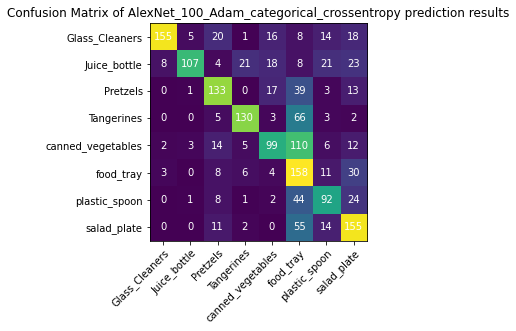

time: 986 ms (started: 2020-12-23 09:56:26 +00:00)


In [12]:
#@title # Results plotting
from sklearn.metrics import classification_report, confusion_matrix

Ypred = np.argmax(results, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(name)

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

fig, ax = plt.subplots()

confusion = tf.math.confusion_matrix(Ytest, Ypred)
img = ax.imshow(confusion)

ax.set_xticks(np.arange(len(classnames)))
ax.set_xticklabels(classnames)

ax.set_yticks(np.arange(len(classnames)))
ax.set_yticklabels(classnames)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

nda_confusion = np.array(confusion)

for i in range(len(classnames)):
    for j in range(len(classnames)):
        text = ax.text(j, i, nda_confusion[i, j], ha="center", va="center", color="w")

ax.set_title("Confusion Matrix of "+name+" prediction results")
plt.show()